<a href="https://colab.research.google.com/github/Spocklight/Fake_News_Detection/blob/master/Master_TopicModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Detección de noticias falsas</center></h1>
<h3><center>Alejandro Sierra Fernández</center></h3>
<h4><center>01/08/2022</center></h4>

*   <h2>Bigramas, filtro gramatical y Topic Modelling</h2>

<font color='darkblue'> En este Notebook aplicaremos distintas funcionalidades que nos ofrece la librería *Gensim* para generar bigramas en nuestros documentos y para filtrar nuestros *tokens* según su pertenencia a las diferentes categorías gramaticales. Por último, aplicaremos la técnica conocida como *Topic Modelling* para asociar nuestros documentos a diferentes categorías temáticas que surgen de la distribución semántica de los mismos. Dicho de otro modo, nuestros documentos están formados palabras que serán representadas por vectores. Dependiendo de la distribución que tenga nuestro conjunto de documentos dentro de este espacio vectorial, podremos definir una serie de clústers que identifiquen cada una de las noticias. De este modo obtendremos una nueva variable que sustituya a la columna *'subject'*, que ya vimos que no nos era de mucha utilidad al estar definida de forma diferente en los datasets de noticias falsas y verdaderas</font>

<font color='darkblue'> Empezamos importando las librerías que vamos a emplear y los dataframes ya preprocesados:</font>

In [ ]:
!pip install --upgrade gensim
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from tqdm.autonotebook import tqdm  
tqdm.pandas()

import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=a6fb64ffeb0a5b93eeba35f2dc44b82b2c3810e681e7f873301e1d0fab5dec47
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=0e6ec50e8fe2

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle                                    
path = '/content/drive/MyDrive/Fake_News/'
pickle_in = open(path + 'ISOT_pickle', 'rb')
ISOT = pickle.load(pickle_in)

In [ ]:
display(ISOT.dtypes)

title                    object
text                     object
subject                  object
date                     object
normaliza_text           object
normaliza_title          object
clean_text               object
clean_title              object
char_len_title            int64
char_len_text             int64
char_len_title_t          int64
char_len_text_t           int64
token_text_len            int64
token_title_len           int64
prop_uppercase_text     float64
prop_uppercase_title    float64
prop_long_text          float64
prop_long_title         float64
target                   object
dtype: object

<font color='darkblue'> Pasamos ahora a formar los bigramas haciendo uso del método *Phrases* que nos ofrece *Gensim*. El funcionamiento de esta herramienta podemos encontrarlo en el famoso paper de Mikolov de 2013 que podemos encontrar en el apartado 4 del mismo:</font>

https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf

In [ ]:
bigram = gensim.models.Phrases(ISOT['normaliza_text'], min_count=10, threshold=100) 
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [ ]:
bigram_mod

<font color='darkblue'> Definimos ahora una primera función para generar una lista que ya incluya los bigramas de cada noticia. La segunda función la emplearemos para filtrar las categorías gramaticales. Esto lo hacemos a través del modelo pre-entrenado de spacy *'en_core_web_sm'*.

La lista con la nomenclatura de las categorías gramaticales podemos encontrarla en el siguiente enlace: </font>

https://machinelearningknowledge.ai/tutorial-on-spacy-part-of-speech-pos-tagging/#Spacy_POS_Tags_List

In [ ]:
def make_bigrams(textos):
    return [bigram_mod[doc] for doc in textos]

def filtra_tags(textos, tags_permitidas=['NOUN', 'ADJ', 'VERB', 'ADV']):
    textos_out = []
    for sent in textos:
        doc = nlp(" ".join(sent)) 
        textos_out.append([token.text for token in doc if token.pos_ in tags_permitidas])
    return textos_out

In [ ]:
#Esta celda tarda aproximadamente una hora en computarse
ISOT_bigrams = make_bigrams(ISOT['normaliza_text'])
ISOT_pos = filtra_tags(ISOT_bigrams, tags_permitidas = ["NOUN", "ADJ", "ADV", 'VERB',  'PROPN']) 

<font color='darkblue'> Podemos comparar el número de tokens antes y después de hacer el filtrado de las categorías gramaticales de, por ejemplo, la primera noticia. Esta reducción de tokens nos permite aligerar el peso de nuestro dataset pensando en el entrenamiento de futuros modelo. Además, no perdemos información relevante al mantener las categorías más relevantes (sustantivos, nombres propios, verbos...)</font>

In [ ]:
print("Numero tokens antes de filtrar: {} tokens".format(len(ISOT_bigrams[0])))
print("Numero tokens despues de filtrar: {} tokens".format(len(ISOT_pos[0])))

Numero tokens antes de filtrar: 222 tokens
Numero tokens despues de filtrar: 216 tokens


In [ ]:
print(ISOT_pos[50])

['fear', 'purge', 'personnel', 'base', 'ideology', 'reach', 'state', 'department', 'department_homeland', 'security', 'new', 'unusual', 'request', 'donald', 'trump', 'transition_team', 'surface', 'incoming', 'trump', 'team', 'demand', 'list', 'name', 'donald', 'trump', 'transition_team', 'ask', 'cabinet', 'department', 'name', 'government', 'official', 'work', 'program', 'counter', 'violent_extremism', 'accord', 'document', 'see', 'reuters', 'request', 'state', 'department', 'department_homeland', 'security', 'involve', 'set', 'program', 'seek', 'prevent', 'violence', 'extremist', 'stripe', 'include', 'recruitment', 'militant', 'islamist', 'group', 'united_states', 'determine', 'trump', 'team', 'ask', 'name', 'trump', 'team', 'request', 'often', 'attack', 'president', 'obama', 'team', 'include', 'former', 'secretary', 'state', 'hillary', 'clinton', 'tough', 'extremist', 'often', 'critique', 'include', 'complaint', 'obama', 'subordinate', 'explicitly', 'blame', 'islamic', 'faith', 'rath

In [ ]:
list1 = [x for x in ISOT_pos if x != []]

In [ ]:
print(len(ISOT_pos))
print(len(list1))

38271
38265


In [ ]:
index_drop = [i for i,x in enumerate(ISOT_pos) if not x] #Índices de listas vacías de la lista ISOT_pos
index_drop

[12408, 16725, 17743, 20195, 27190, 33448]

In [ ]:
display(ISOT["normaliza_text"].iloc[12408])
display(ISOT["normaliza_text"].iloc[16725])
display(ISOT["normaliza_text"].iloc[17743])
display(ISOT["normaliza_text"].iloc[20195])
display(ISOT["normaliza_text"].iloc[33448])


[]

[]

[]

[]

['yep', 'like']

In [ ]:
display(ISOT["text"].iloc[12408])
display(ISOT["text"].iloc[16725])
display(ISOT["text"].iloc[17743])
display(ISOT["text"].iloc[20195])
display(ISOT["text"].iloc[33448])

'  '

' '

' '

'I VE HAD IT! '

'Yep, she s just like you and me! '

In [ ]:
ISOT = ISOT.drop(index_drop, axis=0)
ISOT.reset_index()

,index,title,text,subject,date,normaliza_text,normaliza_title,clean_text,clean_title,char_len_title,char_len_text,char_len_title_t,char_len_text_t,token_text_len,token_title_len,prop_uppercase_text,prop_uppercase_title,prop_long_text,prop_long_title,target
0,0,China's graft watchdog warns officials over 'c...,BEIJING (Reuters) - Chinese officials trying t...,worldnews,"December 11, 2017","[beijing, reuters, chinese, official, try, hid...","[china, graft, watchdog, warn, official, conce...",beijing reuters chinese official try hide dish...,china graft watchdog warn official conceal ext...,68,2447,55,1583,224,7,0.015938,0.014706,0.187500,0.571429,True
1,1,Hurricane Irma may cut power to over 9 million...,(Reuters) - Hurricane Irma threatens to knock ...,worldnews,"September 8, 2017","[reuters, hurricane, irma, threaten, knock, po...","[hurricane, irma, may, cut, power, 9, million,...",reuters hurricane irma threaten knock power mi...,hurricane irma may cut power 9 million people ...,73,4471,61,3039,453,10,0.032431,0.041096,0.119205,0.400000,True
2,2,BREAKING! Wikileaksâ Julian Assange Explains...,Julian Assange met with John Pilger of Dartmou...,politics,"Nov 4, 2016","[julian, assange, meet, john, pilger, dartmout...","[break, wikileak, julian, assange, explain, tr...",julian assange meet john pilger dartmouth film...,break wikileak julian assange explain trump wi...,170,764,115,485,67,18,0.061518,0.235294,0.194030,0.277778,Fake
3,3,"SUNDAY SCREENING: Guns, Drugs & the CIA (1988)","This week s documentary screening, curated by ...",US_News,"April 2, 2017","[week, documentary, screening, curate, editori...","[sunday, screening, gun, drug, cia, 1988]",week documentary screening curate editorial te...,sunday screening gun drug cia 1988,46,645,34,440,59,6,0.151938,0.434783,0.288136,0.166667,Fake
4,4,Suspected U.S. drone strike targets militants ...,"PARACHINAR/PESHAWAR, Pakistan (Reuters) - A su...",worldnews,"September 15, 2017","[pakistan, reuters, suspect, drone, strike, ki...","[suspect, drone, strike, target, militant, pak...",pakistan reuters suspect drone strike kill thr...,suspect drone strike target militant pakistan ...,81,2159,67,1451,199,9,0.048170,0.049383,0.170854,0.555556,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38260,38266,Indian Hindu tried to raise money with video o...,NEW DELHI (Reuters) - A Hindu man in India tri...,worldnews,"December 14, 2017","[new, delhi, reuters, hindu, man, india, try, ...","[indian, hindu, try, raise, money, video, kill...",new delhi reuters hindu man india try raise mo...,indian hindu try raise money video kill muslim...,73,1918,53,1270,195,9,0.036496,0.041096,0.097436,0.000000,True
38261,38267,Ben Carson Outwits Dimwits On The Viewâ¦A MUS...,The progressive dimwits on The View proved tod...,left-news,"Oct 6, 2015","[progressive, dimwit, view, prove, today, matc...","[ben, carson, outwit, dimwit, viewa, must, watch]",progressive dimwit view prove today match bril...,ben carson outwit dimwit viewa must watch,54,1842,41,1058,153,7,0.025516,0.240741,0.176471,0.000000,Fake
38262,38268,Wheelbarrow bomb kills man pushing it in Somal...,"BOSSASO, SOMALIA S (Reuters) - A wheelbarrow e...",worldnews,"October 24, 2017","[bossaso, somalia, reuters, wheelbarrow, explo...","[wheelbarrow, bomb, kill, man, push, somalia, ...",bossaso somalia reuters wheelbarrow explode ou...,wheelbarrow bomb kill man push somalia puntlan...,73,598,58,424,60,9,0.048495,0.041096,0.133333,0.333333,True
38263,38269,Millions to lose health insurance under Republ...,WASHINGTON (Reuters) - Millions of Americans w...,politicsNews,"March 13, 2017","[washington, reuters, million, americans, woul...","[million, lose, health, insurance, republican,...",washington reuters million americans would los...,million lose health insurance republican plan ...,77,443,66,324,42,8,0.054176,0.025974,0.285714,0.500000,True


In [ ]:
for index in sorted(index_drop, reverse=True):
    del ISOT_pos[index]

In [ ]:
index_drop = [i for i,x in enumerate(ISOT_pos) if not x] 
index_drop

[]

In [ ]:
print(len(ISOT_pos))
print(len(ISOT))

38265
38265


<font color='darkblue'> Incluímos esta nueva columna en nuestro dataframe.</font>

In [ ]:
ISOT["normaliza_b_filter"] = ISOT_pos
display(ISOT.columns)

Index(['title', 'text', 'subject', 'date', 'normaliza_text', 'normaliza_title',
       'clean_text', 'clean_title', 'char_len_title', 'char_len_text',
       'char_len_title_t', 'char_len_text_t', 'token_text_len',
       'token_title_len', 'prop_uppercase_text', 'prop_uppercase_title',
       'prop_long_text', 'prop_long_title', 'target', 'normaliza_b_filter'],
      dtype='object')

<font color='darkblue'> Implementamos ahora *Topic Modelling* con Gensim. Empezamos creando un diccionario de términos haciendo uso del módulo *Corpora* y transformamos nuestro corpus en un *Bag of Words* que queda almacenado en la variable 'corpus':</font>

In [ ]:
import gensim.corpora as corpora
id2word = corpora.Dictionary(ISOT_pos)
print(id2word)

Dictionary<100342 unique tokens: ['accept', 'actually', 'address', 'agency', 'also']...>


In [ ]:
texts = ISOT_pos
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 2), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 2), (56, 2), (57, 1), (58, 2), (59, 2), (60, 1), (61, 2), (62, 2), (63, 1), (64, 1), (65, 1), (66, 1), (67, 4), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 13), (84, 1), (85, 1), (86, 2), (87, 1), (88, 1), (89, 1), (90, 5), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 2), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 2), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [ ]:
print(len(corpus))

38265


<font color='darkblue'>Empleamos los modelos LDA (Latent Dirichlet Allocation) para asociar nuestras noticias a los *topics*. Estos modelos, además de los vectores de entrada, necesitan un número de "topics" para ser entrenados. Como no sabemos a priori qué valor es el más óptimo, definimos la función "calculo_valor_coherencia" que a partir del corpus, el diccionario y otros parámetros, calcula un modelo lda y devuelve la coherencia entre sus topics. La definición de esta función nos permitirá realiza un GridSearch para optimizar el número de *topics*</font>

In [ ]:
def calculo_valor_coherencia(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=ISOT_pos, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
grid = {}
# Topics range
min_topics = 2
max_topics = 10
step_size = 2
topics_range = range(min_topics, max_topics, step_size)
alpha = 0.01
beta = 0.9
num_of_docs = len(corpus)
corpus_sets = corpus
corpus_title = '100% Corpus'
model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []}

from tqdm import tqdm
if 1 == 1:
    pbar = tqdm(total=len(topics_range))
    
    for k in topics_range:
        cv = calculo_valor_coherencia(corpus=corpus, dictionary=id2word,
                                    k=k, a=alpha, b=beta)
        
        model_results['Topics'].append(k)
        model_results['Alpha'].append(alpha)
        model_results['Beta'].append(beta)
        model_results['Coherence'].append(cv)
        pbar.update(1)
    pbar.close()

100%|██████████| 4/4 [51:45<00:00, 776.44s/it]


In [ ]:
model_results

{'Topics': [2, 4, 6, 8],
 'Alpha': [0.01, 0.01, 0.01, 0.01],
 'Beta': [0.9, 0.9, 0.9, 0.9],
 'Coherence': [0.32025245231938315,
  0.4093103785676511,
  0.3600231462144261,
  0.45829149761343524]}

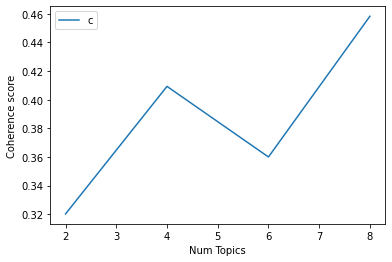

In [ ]:
import matplotlib.pyplot as plt
plt.plot(topics_range, model_results["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=8, 
                                      random_state=100,
                                      chunksize=100,
                                      passes=10,
                                      alpha=0.01,
                                      eta=0.9)

<font color='darkblue'> Definimos ahora nuestro modelo y con la librería *pyLDAvis* visualizamos en un gráfico interactivo los términos más relevantes de cada *topic* y la distancia entre ellos en un espacio bidimensional a través de transformaciones vectoriales.</font>

In [ ]:
model_topics = lda_model.show_topics(formatted=False)
print(lda_model.print_topics(num_words=3))

[(0, '0.014*"quot_quot" + 0.014*"quot" + 0.011*"amp_amp"'), (1, '0.009*"people" + 0.008*"say" + 0.005*"police"'), (2, '0.027*"say" + 0.008*"government" + 0.008*"state"'), (3, '0.046*"trump" + 0.015*"say" + 0.010*"president"'), (4, '0.029*"say" + 0.010*"president" + 0.009*"united_states"'), (5, '0.023*"say" + 0.008*"state" + 0.007*"house"'), (6, '0.020*"say" + 0.016*"party" + 0.011*"government"'), (7, '0.017*"say" + 0.009*"investigation" + 0.009*"report"')]


In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.126774  0.140936       1        1  24.946819
5      0.113553 -0.025814       2        1  21.714527
1      0.064263  0.149104       3        1  18.073923
4      0.046225 -0.118778       4        1  10.480580
2     -0.007544 -0.105922       5        1   8.708153
7      0.012189 -0.027791       6        1   8.672477
6      0.012479 -0.062577       7        1   6.754004
0     -0.367940  0.050841       8        1   0.649517, topic_info=            Term           Freq          Total Category  logprob  loglift
543        trump  103429.000000  103429.000000  Default  30.0000  30.0000
112          say  138801.000000  138801.000000  Default  29.0000  29.0000
90         party   17337.000000   17337.000000  Default  28.0000  28.0000
388      clinton   20016.000000   20016.000000  Default  27.0000  27.0000
399   government   22860.000000   22860.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
6175         amp      98.768845     163.634797   Topic8  -6.2098   4.5318
352        storm     139.873950     623.895011   Topic8  -5.8618   3.5415
627          oil     161.003860    1972.156556   Topic8  -5.7212   2.5312
220      florida     153.877033    2705.770654   Topic8  -5.7664   2.1697
251       island     108.637084    1757.283248   Topic8  -6.1146   2.2532

[621 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
16372      1  0.004086  abadi
16372      2  0.004086  abadi
16372      3  0.004086  abadi
16372      4  0.004086  abadi
16372      5  0.976665  abadi
...      ...       ...    ...
21926      4  0.021149  zinke
21926      5  0.021149  zinke
21926      6  0.021149  zinke
21926      7  0.021149  zinke
21926      8  0.867098  zinke

[3678 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 2, 5, 3, 8, 7, 1])

<font color='darkblue'> Finalmente asociamos cada noticia al *topic* de mayor relevancia en la misma haciendo uso de la función *select_topic*, visualizamos su *countplot* y guardamos el dataframe:</font>

In [ ]:
ISOT["topic_modelling"] = lda_model.get_document_topics(corpus)

In [ ]:
def select_topic(list):
  return max(list, key = lambda i : i[0])[0]

In [ ]:
ISOT["topic_modelling_max"] = ISOT["topic_modelling"].progress_apply(lambda x: select_topic(x))

  0%|          | 0/38265 [00:00<?, ?it/s]

In [ ]:
ISOT.dtypes

title                    object
text                     object
subject                  object
date                     object
normaliza_text           object
normaliza_title          object
clean_text               object
clean_title              object
char_len_title            int64
char_len_text             int64
char_len_title_t          int64
char_len_text_t           int64
token_text_len            int64
token_title_len           int64
prop_uppercase_text     float64
prop_uppercase_title    float64
prop_long_text          float64
prop_long_title         float64
target                   object
normaliza_b_filter       object
topic_modelling          object
topic_modelling_max       int64
dtype: object

In [ ]:
ISOT['topic_modelling_max'][100:105]

100    7
101    7
102    6
103    5
104    6
Name: topic_modelling_max, dtype: int64

In [ ]:
import seaborn as sns

7    34.707958
5    28.684176
6    15.267215
3    10.686005
4     8.051744
2     1.604600
1     0.995688
0     0.002613
Name: topic_modelling_max, dtype: float64

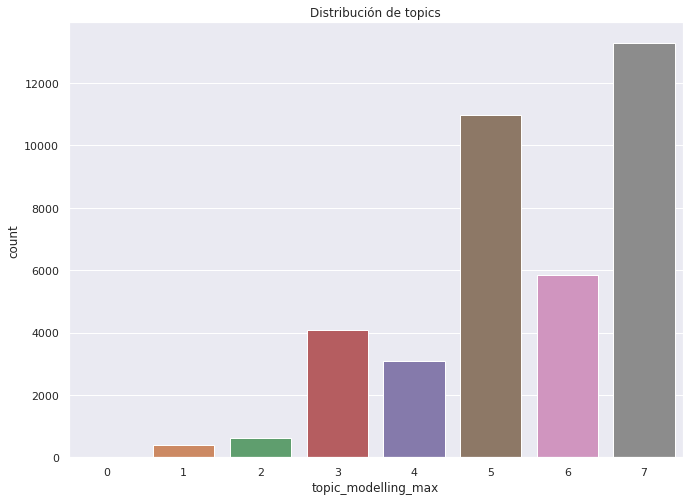

In [ ]:
display(ISOT["topic_modelling_max"].value_counts(normalize=True)*100)
sns.set(rc={'figure.figsize':(11.0,8.0)})
ax = sns.countplot(x="topic_modelling_max", data = ISOT).set(title='Distribución de topics')

In [ ]:
path = '/content/drive/MyDrive/Fake_News/'
pickle_out = open(path + 'ISOT_topic_pickle', 'wb')
pickle.dump(ISOT, pickle_out)
pickle_out.close()